### Principal Component Analysis applied to tidal gauge data along the Dutch coast 

This notebook describes the implementation of the Principal Component Analysis on the sea levels of the main six tidal gauges in the Netherlands. Regression analysis of the sea levels measured at the Dutch tidal gauges show that the linear trend in the sea level differs from station to station. Also, the level is not constant along the coast. Can we explain regional differences by geographical location? We apply a PCA to find the components that explain the variation in the signal. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import nbformat
from tqdm import tqdm_notebook as tqdm
sns.set_style('whitegrid')
%matplotlib inline

#### preparation dataset

In [2]:
def execute_notebook(nbfile):
    with io.open(nbfile, encoding="utf8") as f:
        nb = nbformat.read(f, as_version=4)

    ip = get_ipython()

    for cell in tqdm(nb.cells):
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.source)

In the notebook `'prepare dataframe for PCA analysis.ipynb'` a pandas DataFrame is prepared with monthly sea levelss (mm+NAP) from the 6 main tidal gauges (IJmuiden, Vlissingen, Hoek van Holland, Den Helder, Delfzijl en Harlingen). The sea levels originate from PSMSL in RLR vertical reference and were converted to NAP.

In [3]:
execute_notebook('prepare dataframe for PCA analysis.ipynb')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


As the external notebook has succesfully runned, we now have a dataframe `df` with the monthly sea levels observations from 1930 and onwards. As mentioned before, the prepared dataframe is in mm+NAP

In [4]:
df.head()

,IJMUIDEN,VLISSINGEN,HOEK VAN HOLLAND,DEN HELDER,DELFZIJL,HARLINGEN
year,,,,,,
1930.0416,-64.0,-128.0,-61.0,-17.0,13.0,57.0
1930.1250,-391.0,-355.0,-336.0,-343.0,-336.0,-351.0
1930.2084,-231.0,-224.0,-190.0,-213.0,-159.0,-151.0
1930.2916,-235.0,-206.0,-166.0,-239.0,-218.0,-209.0
1930.3750,-190.0,-185.0,-126.0,-204.0,-136.0,-132.0


We start with an explorative analysis of the dataset by plotting the pairwise relations between the different stations as an indication of the correlation between the tidal gauges. 

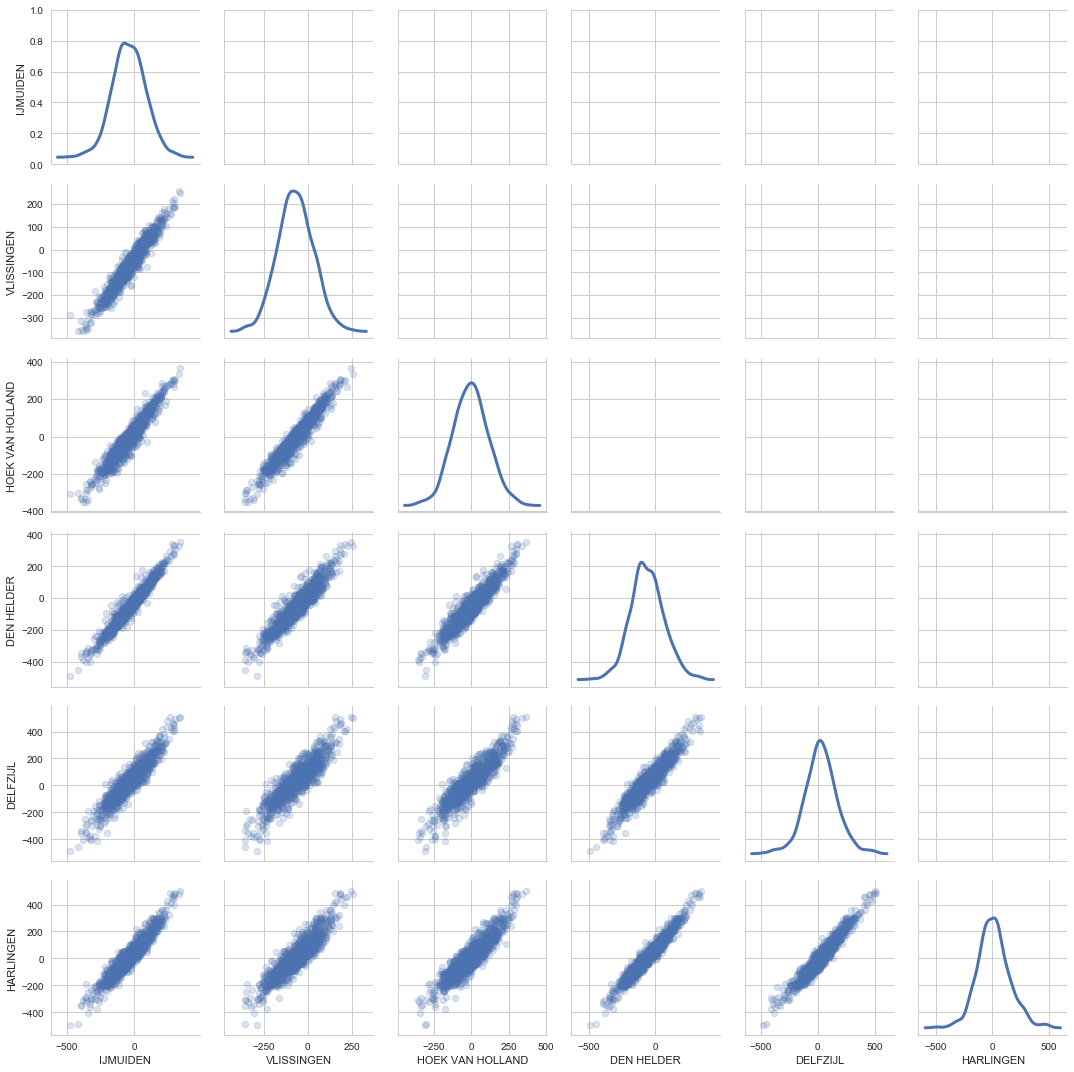

In [5]:
# explorative analysis of the dataset
g = sns.PairGrid(df)
g = g.map_lower(plt.scatter, linewidths=1, facecolor="#4C72B0",
                edgecolor="#4C72B0", s=40, alpha=0.2)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

It is clear that there is a relationship between the different tidal gauges, but this relationship is not identical between all stations. Using the principal components analysis we can quantify the relationship by detecting the principal axes in the data. These axes might become useful to describe and explain the regional differences.

#### Principal Component Analysis: elaboration using two tidal gauge stations

As principal component analysis belongs to the group of unsupervised classification methods it is recommended to standardize the dataset. We first apply the PCA on two tidal gauges to analyse the different components of the analysis and to understand how the principal axes can be used to describe the dataset. 

Once we have a good understanding of PCA we can adopt the method to explain the regional differences on the sea levels of all tidal gauges along the Dutch coast under the assumption that the shared variance of the principal components can differentiate between the shared/common part of sea levelss and the regional influences of the sea levelss.

In this section we show what it means to apply PCA to derive a projection of solely the first principal axes using the tidal gauges of Delfzijl and Hoek van Holland.

In [6]:
# show principe of PCA analysis on two stations
# convert DataFrame to Numpy matrix
X = df[['DELFZIJL', 'HOEK VAN HOLLAND']].fillna(df.mean()).as_matrix()

# calculate mean of timeseries for each station
# calculate standard deviation of timeseries for each station
# standardize the input
_mu = np.nanmean(X, axis=0)
_sigma = np.sqrt(np.nanmean((X - _mu) ** 2.0, axis=0))
X = (X - _mu) / _sigma

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

PCA fundamentally seeks vectors within the dataset along with the variance is mazimized. The fit of the `PCA` estimator from Scikit-Learns can do this by learning some quantities from the data. Using the variable `components_` it is possible to define the direction of the vector, where the `explained_variance_` can be used to define the squared-lenght of the vector. Here we choose to describe the relationship between the tidal gauge station of Delfzijl and Hoek van Holland along two principal axes

In [7]:
pca.components_

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

In [8]:
pca.explained_variance_

array([ 1.91398928,  0.08792827])

To see what these numbers mean we can plot the standarized sea levelss of both tidal gauge stations and the direction and squared-length of each of the vector along the variance is maximized.

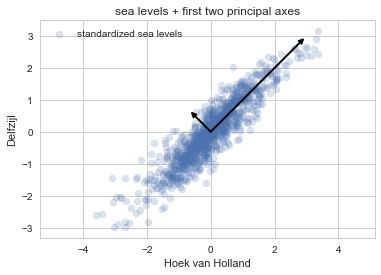

In [9]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                      linewidth=2,
                      shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)


# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='standardized sea levels')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')
plt.legend()
plt.xlabel('Hoek van Holland')
plt.ylabel('Delfzijl')
plt.title('sea levels + first two principal axes')
plt.show()

The points represent the measured (but standardized) monthly sea levels observations of the two tidal gauge stations and the vectors represent the first two princal components. The first principal component follows the direction in the dataset along its variance can be maximized. The direction of the second principal component is orthogonal on the first principal component fiting the maximaum remaining variance.

Here we used the tidal gauges as `x` and `y` axes, but it is also possible to use the first principal components as `x` and `y` axes.

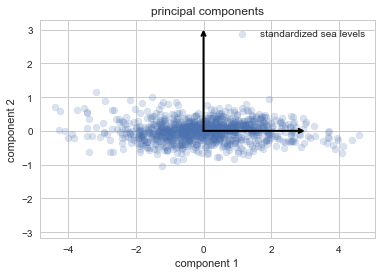

In [10]:
# plot principal components
X_pca = pca.transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2,
            label='standardized sea levels')
draw_vector([0, 0], [0, 3])
draw_vector([0, 0], [3, 0])
plt.legend()
plt.axis('equal')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('principal components')
plt.show()

Here we used `component 1` for the `x` axes and `component 2` for the `y` axes, where the blue dots represent the standardized sea levels observations. From the figure can be seen that the maximum variance of the data is indeed in the first principal component of the observations.

Since the first principal component explains most of the variance, we expect that the first component explains the common part of the sea levels observations at the two tidal gauges. 

In [11]:
print('differences between the portion of explained variance in %:')
expvar_pct = pca.explained_variance_/pca.explained_variance_.sum() * 100
print('component 1: {}'.format(round(expvar_pct[0], 2)))
print('component 2: {}'.format(round(expvar_pct[1], 2)))

differences between the portion of explained variance in %:
component 1: 95.61
component 2: 4.39


In other words, the first component preserves the maximal data variance of the original observations whereas the second component explains the remainder including the individual part of the tidal gauge stations than can explain the regional differences. 

Since we expect that the first component describes the common part of the sea levels observations at the two tidal gauge stations we now can use this component to transform this dataset so that the variance is only explained along the first component. Essentially we are reducing the number of dimensions.

In [12]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("orginal dataset:        ", X.shape)
print("transformed dataset:    ", X_pca.shape)

orginal dataset:         (1044, 2)
transformed dataset:     (1044, 1)


The orignal dataset consist of `1044` monthly sea levels observations for the `2` tidal gauge station of Delfzijl and Hoek van Holland. The lower-dimensional projection of the transformed dataset consist of `1044` monthly sea levels observations and the first principal component (`1`) that explains the maximal variance of the two tidal gauge stations.

The original dataset is now transformed to `1` dimension. Now, we can perform the inverse transform on this lower-dimensional projection, destandardize the dataset and plot it in combination with the original dataset.

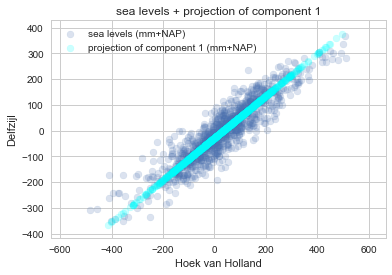

In [13]:
X_new = pca.inverse_transform(X_pca)
X_new *= _sigma
X_new += _mu
X *= _sigma
X += _mu
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='sea levels (mm+NAP)')
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.2, color='cyan',
            label='projection of component 1 (mm+NAP)')
plt.legend()
plt.axis('equal')
plt.xlabel('Hoek van Holland')
plt.ylabel('Delfzijl')
plt.title('sea levels + projection of component 1')
plt.show()

The light blue dots represent the pairwise relation of the original sea levels observations of the two stations, where the dots in cyan represents the projected observations along the most important principal axis or component with the higest variance.

#### PCA analysis on 6 tidal gauges along the Dutch coast 

In the previous section we elaborated on the application of PCA, with a showcase how the projected dataset will look like if we describe the pairwise relationship between Delfzijl and Hoek van Holland by solely its first principal axes. 

In this section we shall apply PCA using the six main tidal gauge stations along the Dutch coast. Where we try to identify how many of the six corresponding should be used to explain the common part of the dataset.

In [14]:
# PCA method of statsmodules module includes standardization
from statsmodels.multivariate.pca import PCA
pca = PCA(df.fillna(df.mean()))

In [15]:
# data muggling as preparation for the figure
tot = np.ceil(sum(pca.eigenvals)).astype(int)
var_exp = np.array([(i / tot)*100 for i in pca.eigenvals])
cum_var_exp = np.cumsum(var_exp)
eigenvals_norm = np.array([i * 1/(tot/df.shape[1]) for i in pca.eigenvals])
tot_norm = np.ceil(sum(eigenvals_norm)).astype(int)
x_ = np.arange(1, int(tot_norm)+1, 1)

Adoption of the PCA analysis on the six tidal gauge stations results in six  principal components, where each orthogonal principal component tries to maximize the variance it can explains and the sum of these explained variance correspond to the total variance in the signal.

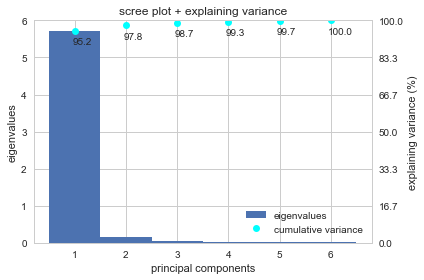

In [16]:
fig, ax_l = plt.subplots()

ax_l.bar(x_, eigenvals_norm, width=1, zorder=10, color="#4C72B0",
        label='eigenvalues')
ax_l.set_xlim(1, 9)
ax_l.set_ylim(0, tot_norm)
ax_l.set_xlabel('principal components')
ax_l.set_ylabel('eigenvalues')
ax_l.set_xticks(x_)

ax_r = ax_l.twinx()
ax_r.plot(x_, cum_var_exp, color='cyan', marker='o', ls='',
         label='cumulative variance')
ax_r.set_ylim(0, 100)
ax_r.set_ylabel('explaining variance (%)')
ax_r.set_yticks(np.around(np.linspace(ax_r.get_yticks()[0],
                                     ax_r.get_yticks()[-1],
                                     len(ax_l.get_yticks())), decimals=2))
ax_r.grid(None)

for i, label, in enumerate([str(np.round(i*100, 1)) for i in pca.rsquare[1:]]):
    z = cum_var_exp
    ax_r.annotate(label, (x_[i]-0.05, z[i]-6))

# ask matplotlib for the plotted objects and their labels
lines, labels = ax_l.get_legend_handles_labels()
lines2, labels2 = ax_r.get_legend_handles_labels()
ax_l.legend(lines + lines2, labels + labels2, loc=4)

plt.title('scree plot + explaining variance')
plt.tight_layout()

plt.show()

The figure above shows on the `x` axes the six different deriviated principal components on the left `y` axis the eigenvalues and on the right `y` axes the explained variance. The blue bars represent the eigenvalues and the cyan dots the cumulative variance starting by the first principal component.'

The eigenvalues show a very strong decline over the principal components, where the first principal component can maximize the variance it explains to 95.2% of the dataset, whereas the 2nd and 3rd principal component still can describe  2.6% and 0.9% respectively.

Based on this result we see strong evidence for a common component for the sea level observations of the 6 tidal gauge stations (first principal component), whereas different individual components or a geographically contribution of the Wadden, Hollandse Kust or Zeeland are not observed.

#### Projection of first principal component and remaining components on pairwise relationship of observed sea levelss

In the following section we project both the first principal component and the remaining principal components (principal component 2-6) on the observerd monthly aggregated sea levelss. Using this explorative approach we try to find if the common component contributes more or less to the suggested sea level rise and the influence of the remaining components.

In common adopted `PCA` estimators it is only possible to project component-1 till component-n on the original dataset and not component-2 till component-n. Since we try to find if there are different influences in the common part and the remaining part we prepared a function that does what we want.

In [17]:
def pca_manual(df, ncomp=[0]):
    """
    Applied principal components analysis manually to split the common and
    remaining part
    Input DataFrame is standardized
    Principal components are normalized and output DataFrame is destandardized

    Parameters
    ----
    Input is:
    df    : pandas dataframe
    ncomp : is selection of components
        # select the eigenpairs to be used where
        # [0] is only the 1st principal component
        # [1] is only the 2nd principal component
        # [0,1,2] is the 1st, 2nd and 3rd principal component
        # [1,3] are a combination of the 2nd and 4th principal component

    Output is:
    Pandas DataFrame with the applied components
    """

    # create data array and set index and columns
    _index = df.index
    _columns = df.columns
    X = df.as_matrix()

    # calculate mean of timeseries for each station
    # calculate standard deviation of timeseries for each station
    # standardize the input
    _mu = np.nanmean(X, axis=0)
    _sigma = np.sqrt(np.nanmean((X - _mu) ** 2.0, axis=0))
    X = (X - _mu) / _sigma

    # calculate eigenvalues and eigenvectors using the SVD method
    u, s, v = np.linalg.svd(X)
    # np.sqrt(corrs. eigenvalue via cov matrix) == singular value s
    eigenvals = s ** 2
    eigenvecs = v.T  # vectors are 'column-wise' determined

    # sort and calculate relevance statistics by order of eigenvalues
    indices = np.argsort(eigenvals)
    indices = indices[::-1]  # sort eigenvalues from high to low
    eigenvals = eigenvals[indices]
    eigenvecs = eigenvecs[:, indices]

    # select the eigenpairs for usage
    # [0] correspond to the 1st principal component
    # [1] correspond to the 2nd principal component
    # [0,1,2] correspond to the 1st, 2nd and 3rd principal component
    # [1,3] combination of the 2nd and 4th principal component
    # ncomp = [1]
    eigenvals = eigenvals[ncomp]
    eigenvecs = eigenvecs[:, ncomp]

    # determine the arrays of the principal components
    factors = X.dot(eigenvecs)

    # select correct order of components to return
    loadings = eigenvecs  # V
    coeff = eigenvecs.T  # V'

    # normalize the principal components
    coeff = (coeff.T * np.sqrt(eigenvals)).T
    factors = factors / np.sqrt(eigenvals)

    # project the input datastream on the selected principal components
    # destandardize the projection to input datastrean
    # (as PCA is done on the standardized datastream)
    projection = factors.dot(coeff)
    projection *= _sigma
    projection += _mu

    # return as dataframe
    df_projected = pd.DataFrame(projection, columns=_columns, index=_index)

    return df_projected

In [18]:
ncomp = [0]  # only use the 1st principal component
pca_common = pca_manual(df, ncomp)

We first reduce the variance in the orginal monthly sea level observations using the first principal component:

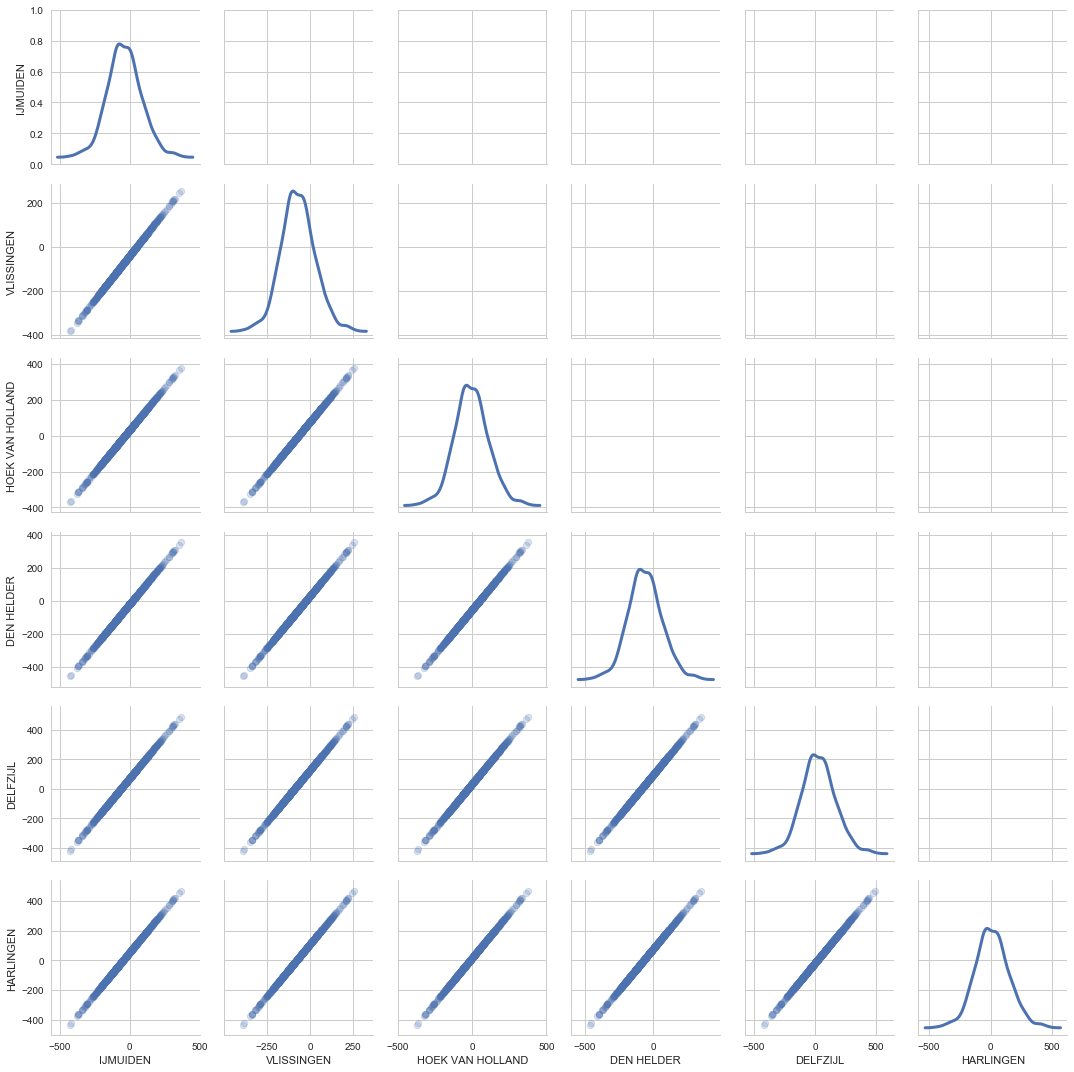

In [19]:
g = sns.PairGrid(pca_common)
g = g.map_lower(plt.scatter, linewidths=1, facecolor="#4C72B0",
                edgecolor="#4C72B0", s=40, alpha=0.2)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

Pairwise relationship of the sea levels (in mm+NAP) from the six tidal gauges reduced by using solely the first principal axes.

We do the same for the remaining components (component 2 till component 6):

In [20]:
# use the remaining components excluding the 1st principal component
ncomp = np.arange(1, df.shape[1])
print(ncomp)
pca_remaining = pca_manual(df, ncomp)

[1 2 3 4 5]


Visualisation of the projected components that describe the remaining part of the pairwise relations between the different tidal gauges. 

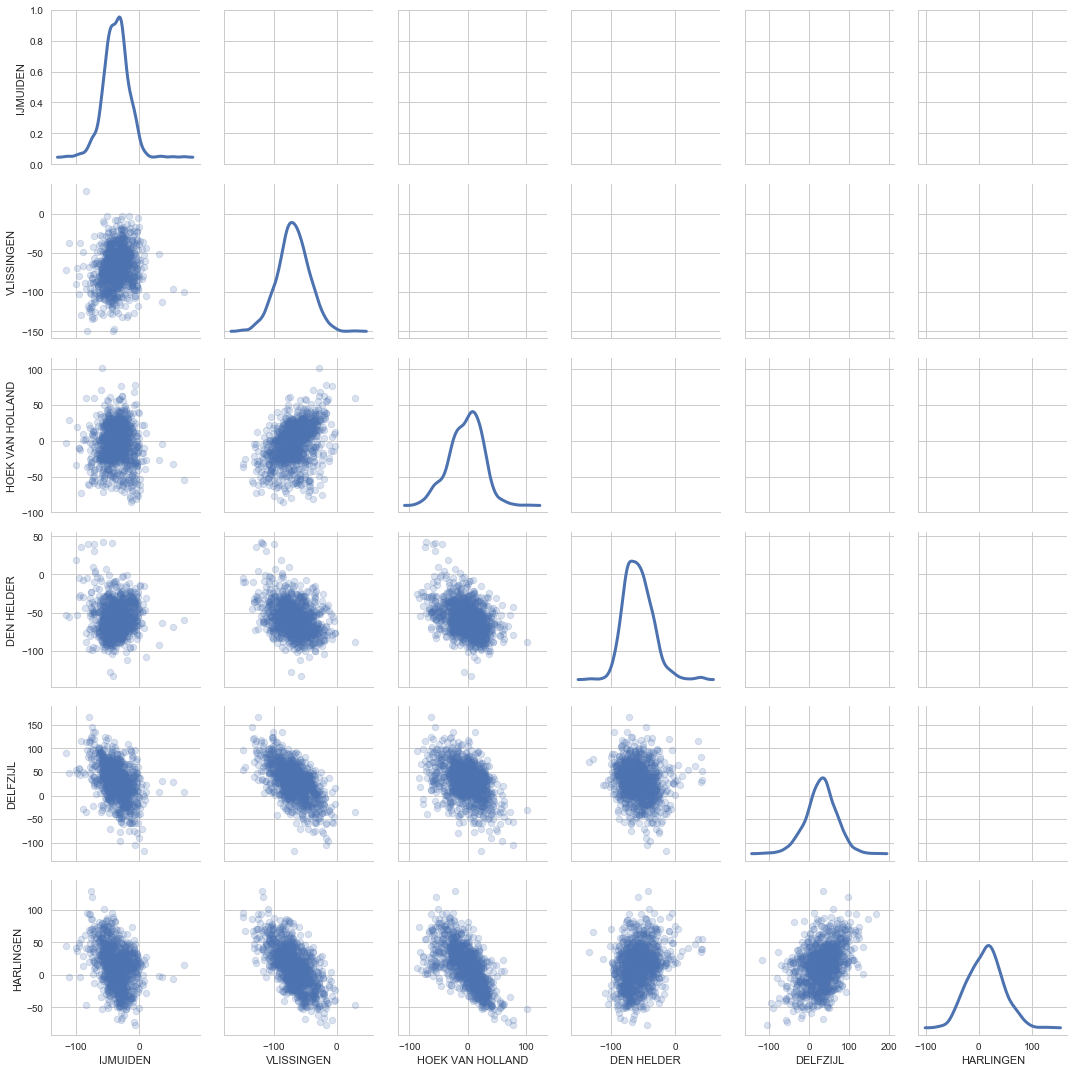

In [21]:
g = sns.PairGrid(pca_remaining)
g = g.map_lower(plt.scatter, linewidths=1, facecolor="#4C72B0",
                edgecolor="#4C72B0", s=40, alpha=0.2)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

The explained variance among the projection of the remaining components on the original sea levels observations (in mm+NAP) confirms the statement that the PCA does not provide evidence for an individual component or geographical components.

Using the two projections we can compute the mean over all stations and compare this with the mean computed over the observerd monthly aggregated sea levelss.

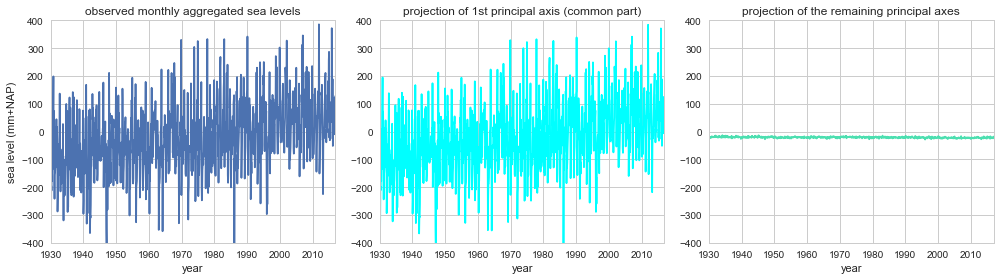

In [22]:
pca_cmmn_mn = pca_common.mean(axis=1)
pca_rmng_mn = pca_remaining.mean(axis=1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

df.mean(axis=1).plot(ax=axes[0],
                     alpha=1, ylim=[-400, 400],
                     title='observed monthly aggregated sea levels')

pca_cmmn_mn.plot(ax=axes[1], color="cyan",
                 alpha=1, ylim=[-400, 400],
                 title='projection of 1st principal axis (common part)')

pca_rmng_mn.plot(ax=axes[2], color="#4CDFB0",
                 ylim=[-400, 400],
                 title='projection of the remaining principal axes')
axes[0].set_ylabel('sea level (mm+NAP)')
plt.tight_layout()
plt.show()

Accordingly we can adopt the linear statistical model (described in `prepare dataframe for PCA analysis.ipnyb`) to get some quick results if the common part shows an upward/downward or similar trend compared to the trend calculated based on the observed sea levels. And similar we can provide an explorative insight of the trend/contribution of the remaining part.

In [23]:
df_mean = pd.DataFrame(data=dict(year=df.index,
                                 height=df.mean(axis=1)))
pca_common_mean = pd.DataFrame(data=dict(year=pca_common.index,
                                         height=pca_common.mean(axis=1)))
pca_remaining_mean = pd.DataFrame(data=dict(year=pca_remaining.index,
                                            height=pca_remaining.mean(axis=1)))
# pca_common_mean.head()

In [24]:
fit_org, names_org = linear_model(df_mean,
                                  with_wind=False,
                                  with_season=False)
fit_pca_gzl, names_pca_gzl = linear_model(pca_common_mean,
                                          with_wind=False,
                                          with_season=False)
fit_pca_idv, names_pca_idv = linear_model(pca_remaining_mean,
                                          with_wind=False,
                                          with_season=False)

In [25]:
pd.DataFrame(np.array([fit_org.aic, fit_pca_gzl.aic, fit_pca_idv.aic]),
             index=['observed monthly aggregated sea levels',
                    'projection of 1st principal axis (common part)',
                    'projection of the remaining principal axes'],
             columns=['AIC'])

,AIC
observed monthly aggregated sea levels,12801.160943
projection of 1st principal axis (common part),12793.424084
projection of the remaining principal axes,4512.364979


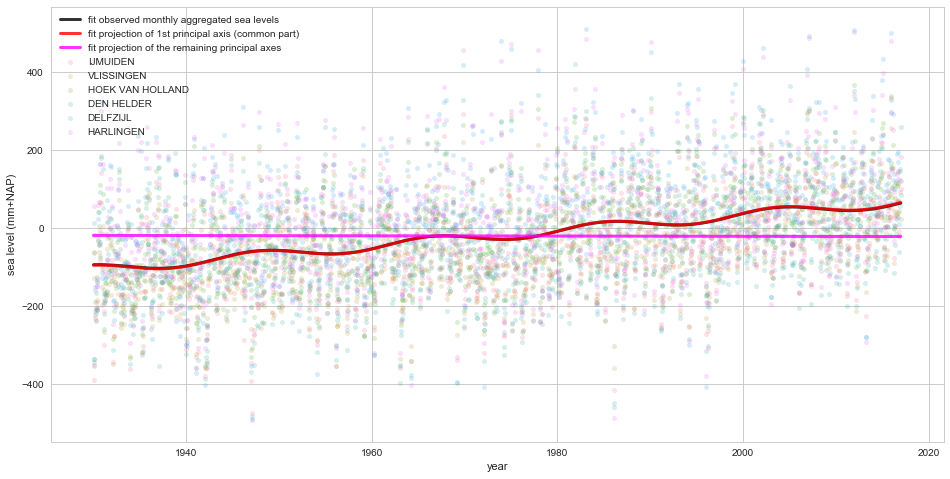

In [26]:
# kleuren voor de stations
colors = sns.color_palette("husl", df.columns.size)

# plot de fit van de orginele data in het lineare model
fig, ax = plt.subplots(figsize=(16, 8))
for ix, column in enumerate(df.columns):
    df.reset_index().plot(x='year', y=column,
                          kind='scatter', ax=ax, alpha=0.2,
                          color=colors[ix], label=column)
ax.plot(fit_org.model.exog[:, 1] + 1970, fit_org.predict(),
        linewidth=3, alpha=0.8, color='k',
        label='fit observed monthly aggregated sea levels')
ax.plot(fit_pca_gzl.model.exog[:, 1] + 1970, fit_pca_gzl.predict(),
        linewidth=3, alpha=0.8, color='r',
        label='fit projection of 1st principal axis (common part)')
ax.plot(fit_pca_idv.model.exog[:, 1] + 1970, fit_pca_idv.predict(),
        linewidth=3, alpha=0.8, color='magenta',
        label='fit projection of the remaining principal axes')
ax.set_ylabel('sea level (mm+NAP)')
ax.legend()
plt.show()

In [27]:
print('trend observed monthly aggregated sea levels:',
      fit_org.params.x1*100.0/10,
      'cm/century\ntrend projection of 1st principal axis (common part)',
      fit_pca_gzl.params.x1*100.0/10,
      'cm/century\ntrend projection of the remaining principal axes',
      fit_pca_idv.params.x1*100.0/10, 'cm/century')

trend observed monthly aggregated sea levels: 19.8524398648 cm/century
trend projection of 1st principal axis (common part) 20.1933790768 cm/century
trend projection of the remaining principal axes -0.340939211999 cm/century


Based on this explarive analysis the common part of the sea level observations result in an higher upward trend compared to the the observerd monthly aggregated sea levels, where the trend of the projection of the remaining principal axes is downward.

#### Short note on PCA and its application on the first discrete difference

Advice: using Principal Component Analysis it is important to have a clear idea about the results of the different estimators. Using numpy arrays the column names are not considered which may lead to confusion and errors down the line. Suggested is to make use of methods that incorporate pandas DataFrame so column names are still present after PCA. 

The application of PCA on the first discrete different following with a cumulative summation, won't change the trend but only will cause a shift in the 'vertical zero point' (and avoids confusion).

In [28]:
diffs = df.diff()
# slice the source dataset
_diffs = diffs.iloc[1::]
_diffs = _diffs.ix[:, 0:-1]
pca_dif = pca_manual(_diffs, [0])

In [29]:
df_dif = pd.DataFrame(data=dict(year=df.index[1:],
                                height=np.cumsum(pca_dif).mean(axis=1)))
fit_dif, names_dif = linear_model(df_dif, with_wind=False, with_season=False)

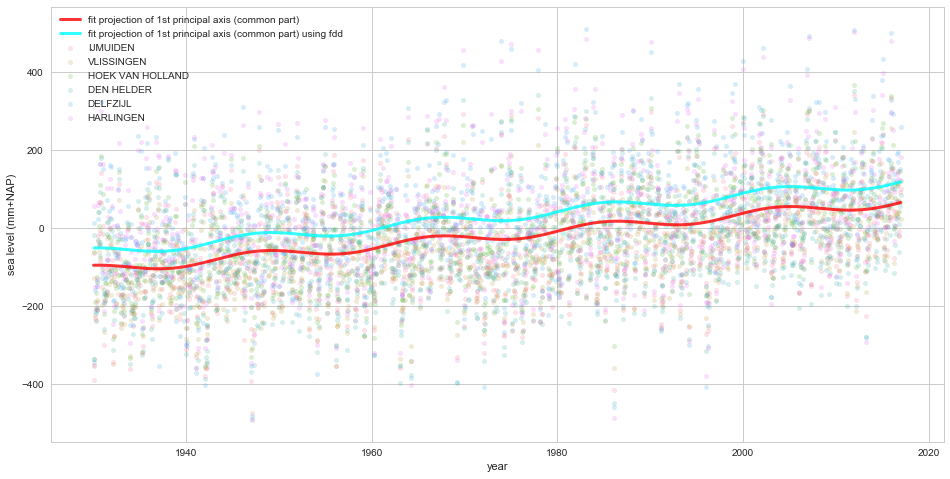

In [30]:
# colors for the stations
colors = sns.color_palette("husl", df.columns.size)

# plot de fit van de orginele data in het lineare model
fig, ax = plt.subplots(figsize=(16, 8))
for ix, column in enumerate(df.columns):
    df.reset_index().plot(x='year', y=column,
                          kind='scatter', ax=ax,
                          alpha=0.2, color=colors[ix], label=column)

# ax.plot(fit_org.model.exog[:, 1] + 1970, fit_org.predict(),
#         linewidth=3, alpha=0.8, color='k',
#         label='fit orginal')

ax.plot(fit_pca_gzl.model.exog[:, 1] + 1970, fit_pca_gzl.predict(),
        linewidth=3, alpha=0.8, color='r',
        label='fit projection of 1st principal axis (common part)')

# ax.plot(fit_pca_idv.model.exog[:, 1] + 1970, fit_pca_idv.predict(),
#         linewidth=3, alpha=0.8, color='magenta',
#         label='fit PCA remaining')

# fdd means first discrete difference
ax.plot(fit_dif.model.exog[:, 1] + 1970, fit_dif.predict(),
        linewidth=3, alpha=0.8, color='cyan',
        label='fit projection of 1st principal axis (common part) using fdd')
ax.set_ylabel('sea level (mm+NAP)')
ax.legend()
plt.show()